In [1]:
#100-80日本海側　計算したものの描画てすと

In [1]:
import math
import csv
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import japanize_matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.util as cutil
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from metpy.units import units
import metpy.calc as mpcalc
import metpy.constants as c
from datetime import datetime, timedelta
from dateutil import relativedelta
from struct import pack, unpack, calcsize, iter_unpack
from PIL import Image
import os
from time import sleep
from multiprocessing import Pool, cpu_count,Manager,Value,Array, Process #並列処理モジュール
from tqdm import tqdm
#from new_colors import * #自作モジュール
import warnings
from datetime import datetime
#警告非表示
# warnings.simplefilter('ignore')

# import warnings
warnings.filterwarnings('ignore')

#描 画 領 域 の 設 定
#日本
#latd=22.50 ; latu=45.00 ; lonl=121.00 ; lonr=149.00

#東北地方
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0


%matplotlib inline

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

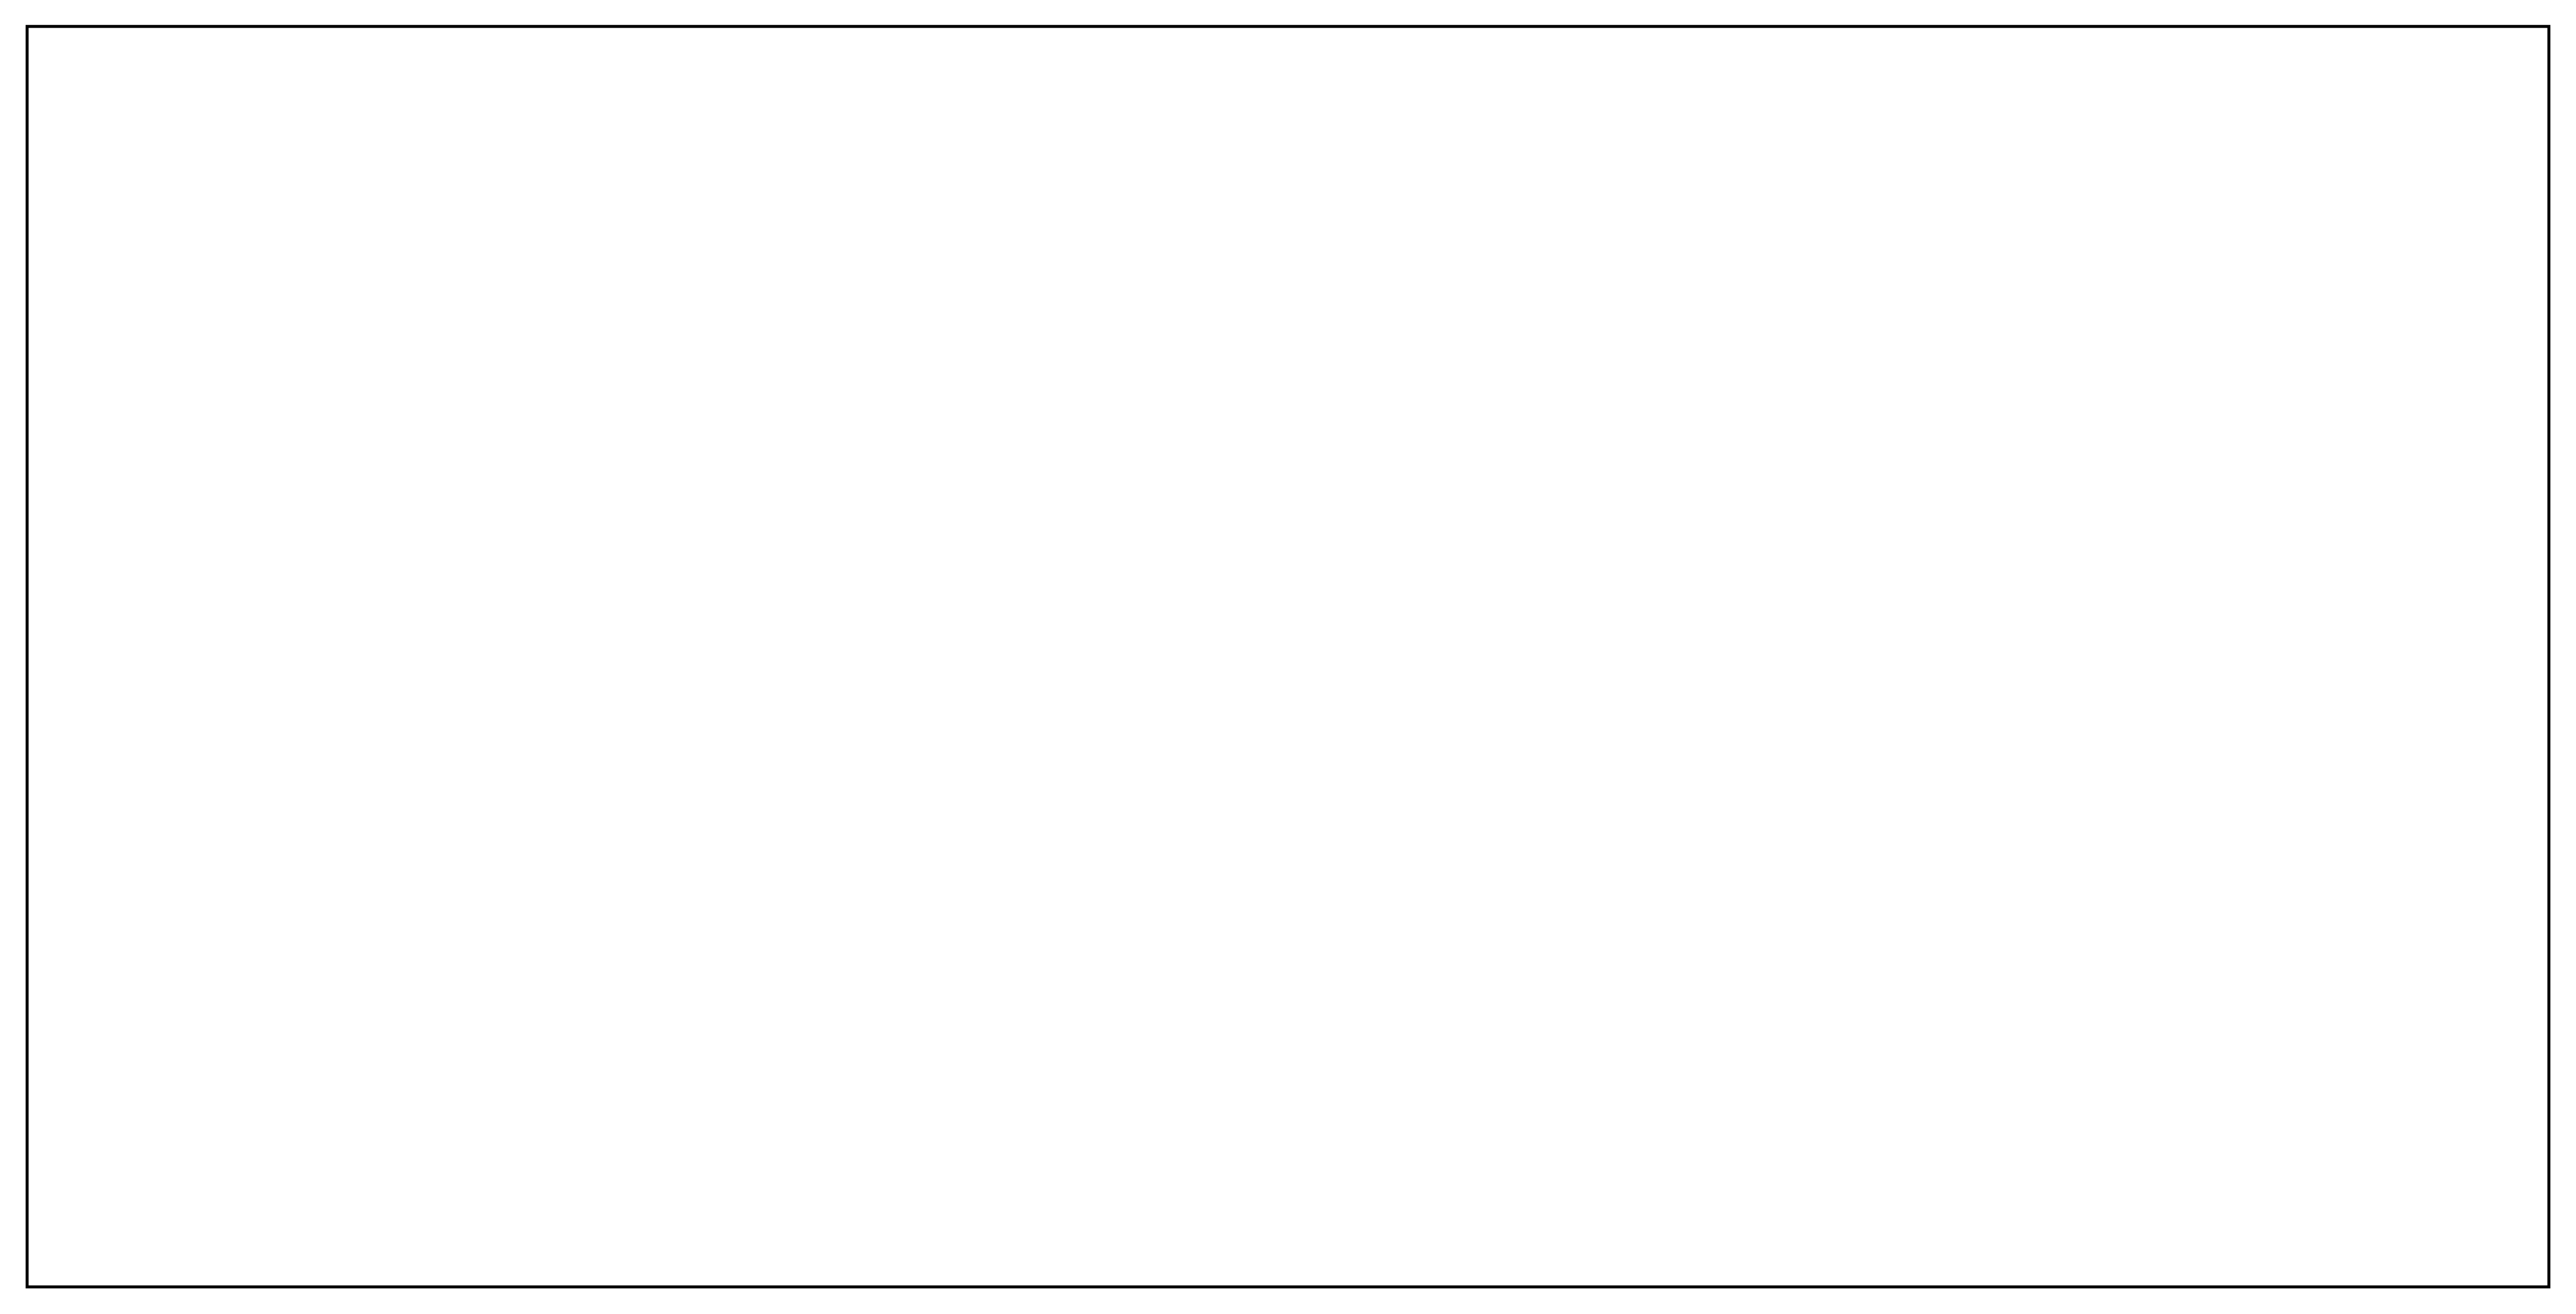

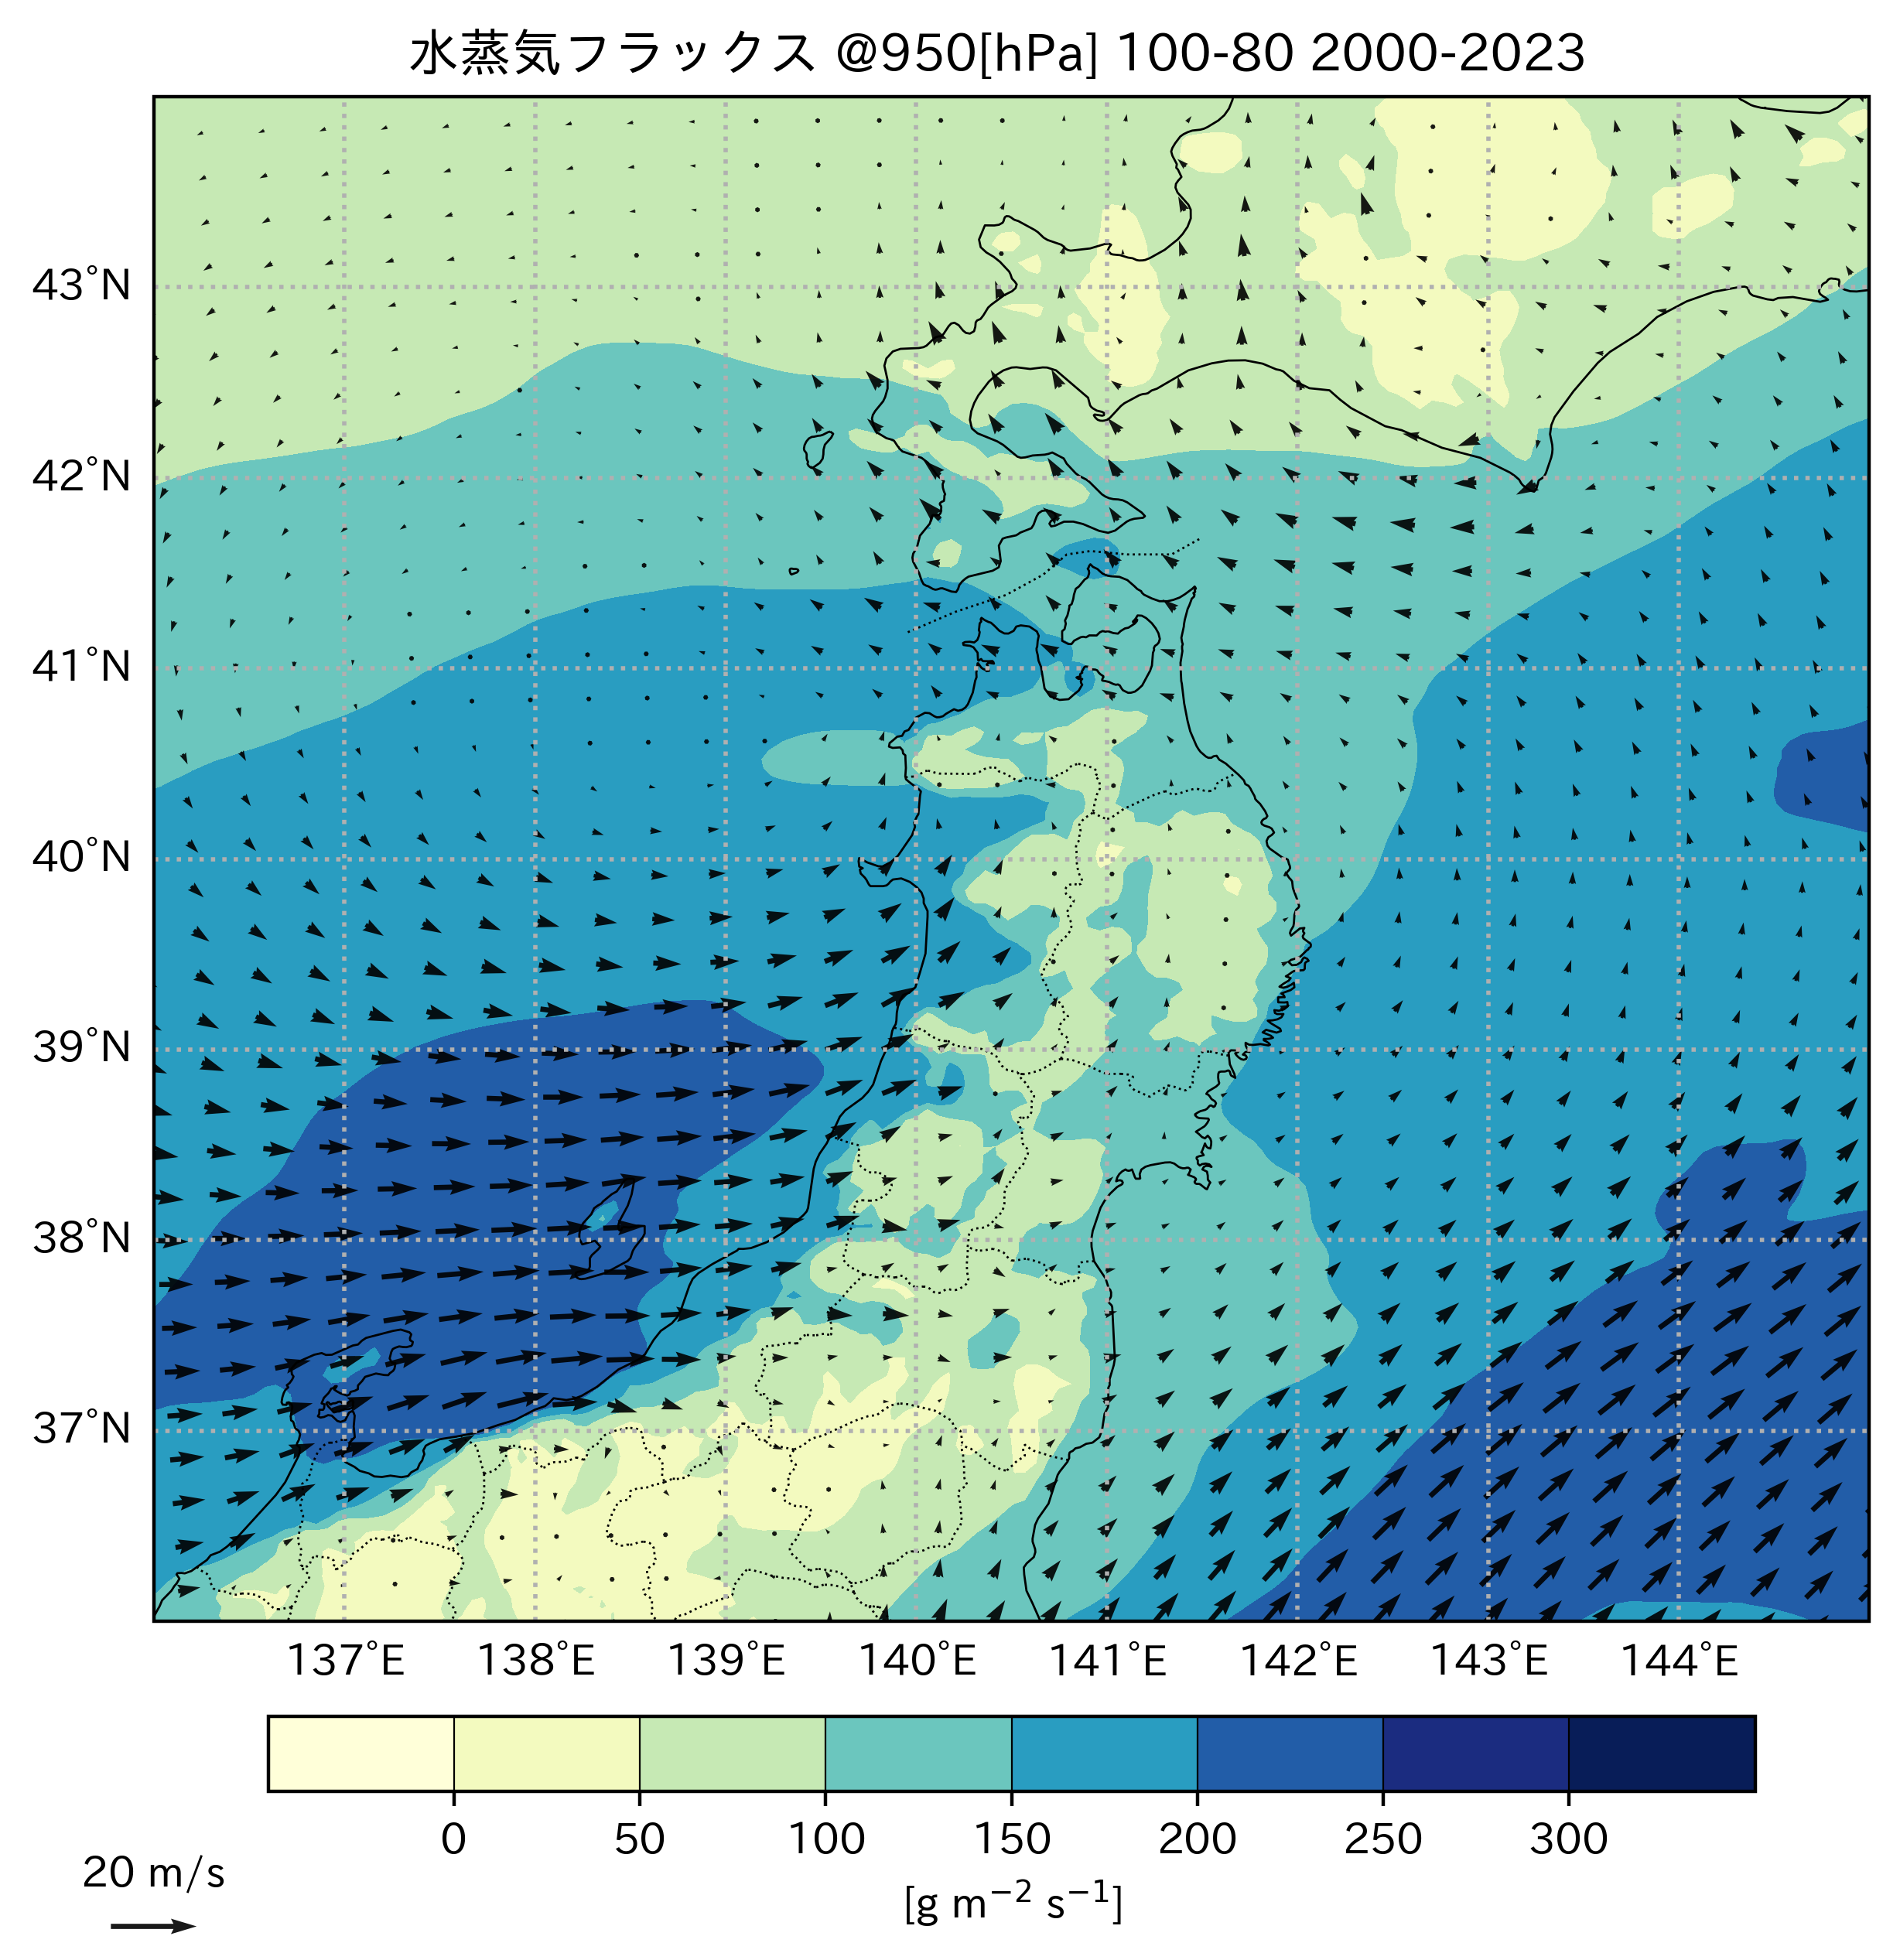

In [8]:
import numpy as np
import xarray as xr
import cfgrib


datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

#latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr#.isel(isobaricInhPa=2)
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV = np.load(f"{datapath}/sum_ave_qV_100-80_25.npy")
sum_ave_U  = np.load(f"{datapath}/sum_ave_U_100-80_25.npy")
sum_ave_V  = np.load(f"{datapath}/sum_ave_V_100-80_25.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_100-80_25.npy")

# ここで平均化
qV_data = sum_ave_qV / 13
U_data  = sum_ave_U  / 13
V_data  = sum_ave_V  / 13
MSLP_data = sum_ave_MSLP/13

# あとはあなたの描画コード（contourf, quiver など）

lat = Ds['latitude'] ; lon = Ds['longitude']#経度緯度
fig = plt.figure(figsize=(12,8),facecolor="white")
plt.rcParams["figure.dpi"] = 400            # dpi(dots per inch)
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())

# 東北領域だけマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data/100, np.nan)  # hPa に変換して描画

# === プロット ===
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection': proj})

cs = ax.contour(lon, lat, mslp_toho, 
                levels=range(980, 1040, 1), 
                colors='white', transform=proj)

ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)


#proj = ccrs.PlateCarree()
#ax.set_extent([lon_l,lon_r,lat_d,lat_u])
#cs = ax.contour(lon, lat, mslp, levels=range(980, 1040, 1), colors='white', transform=proj)
#ax.clabel(cs, inline=True, fontsize=8, fmt="%d", inline_spacing=-2)# ラベルを付ける

#水蒸気フラックス
#im = ax.contourf(lon,lat,qV_data,transform=ccrs.PlateCarree(),cmap='YlGnBu',interpolation='nearest',extend='both')#,cmap='turbo'
#cbar = fig.colorbar(im,ax=ax,orientation='horizontal',pad=0.05,shrink=0.62,extendfrac='auto',extendrect='True',
#                        drawedges=True,label='[g m$^{-2}$ s$^{-1}$]')#######################################
    
countries_10m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines','10m', edgecolor='black', facecolor='none')    

# カラーバーの範囲と刻みを指定
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)

# 等値線塗りつぶし
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels,  # これで色分けの間隔を固定
    cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)

# カラーバー
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,  # 目盛りを固定
    label='[g m$^{-2}$ s$^{-1}$]'
)


#風速

lat = Ds['latitude'].values
lon = Ds['longitude'].values
skip = 5
q1 = ax.quiver(lon[::skip,::skip],lat[::skip,::skip],U_data[::skip,::skip],V_data[::skip,::skip]
                    ,color='black',scale=400,alpha=0.9,width=0.003)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')
    
#東北地方周辺
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0
ax.set_extent([lon_l,lon_r,lat_d,lat_u])
ax.coastlines(resolution='10m',lw=0.5) #海 岸 線 を 追 加
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0) #県 境 を 追 加
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True, linewidth=1, linestyle=':')      # 緯度線、経度線を描く
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))  # 経度線の設定
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))    # 緯度線の設定
gl.top_labels = False
gl.right_labels = False
ax.set_title(f'水蒸気フラックス @950[hPa] 100-80 2000-2023  ',fontsize=12)###################

plt.show()

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1005.060660276139 1009.33925650833
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1005.060660276139 1009.33925650833
13011.653812416156 13188.753646141591


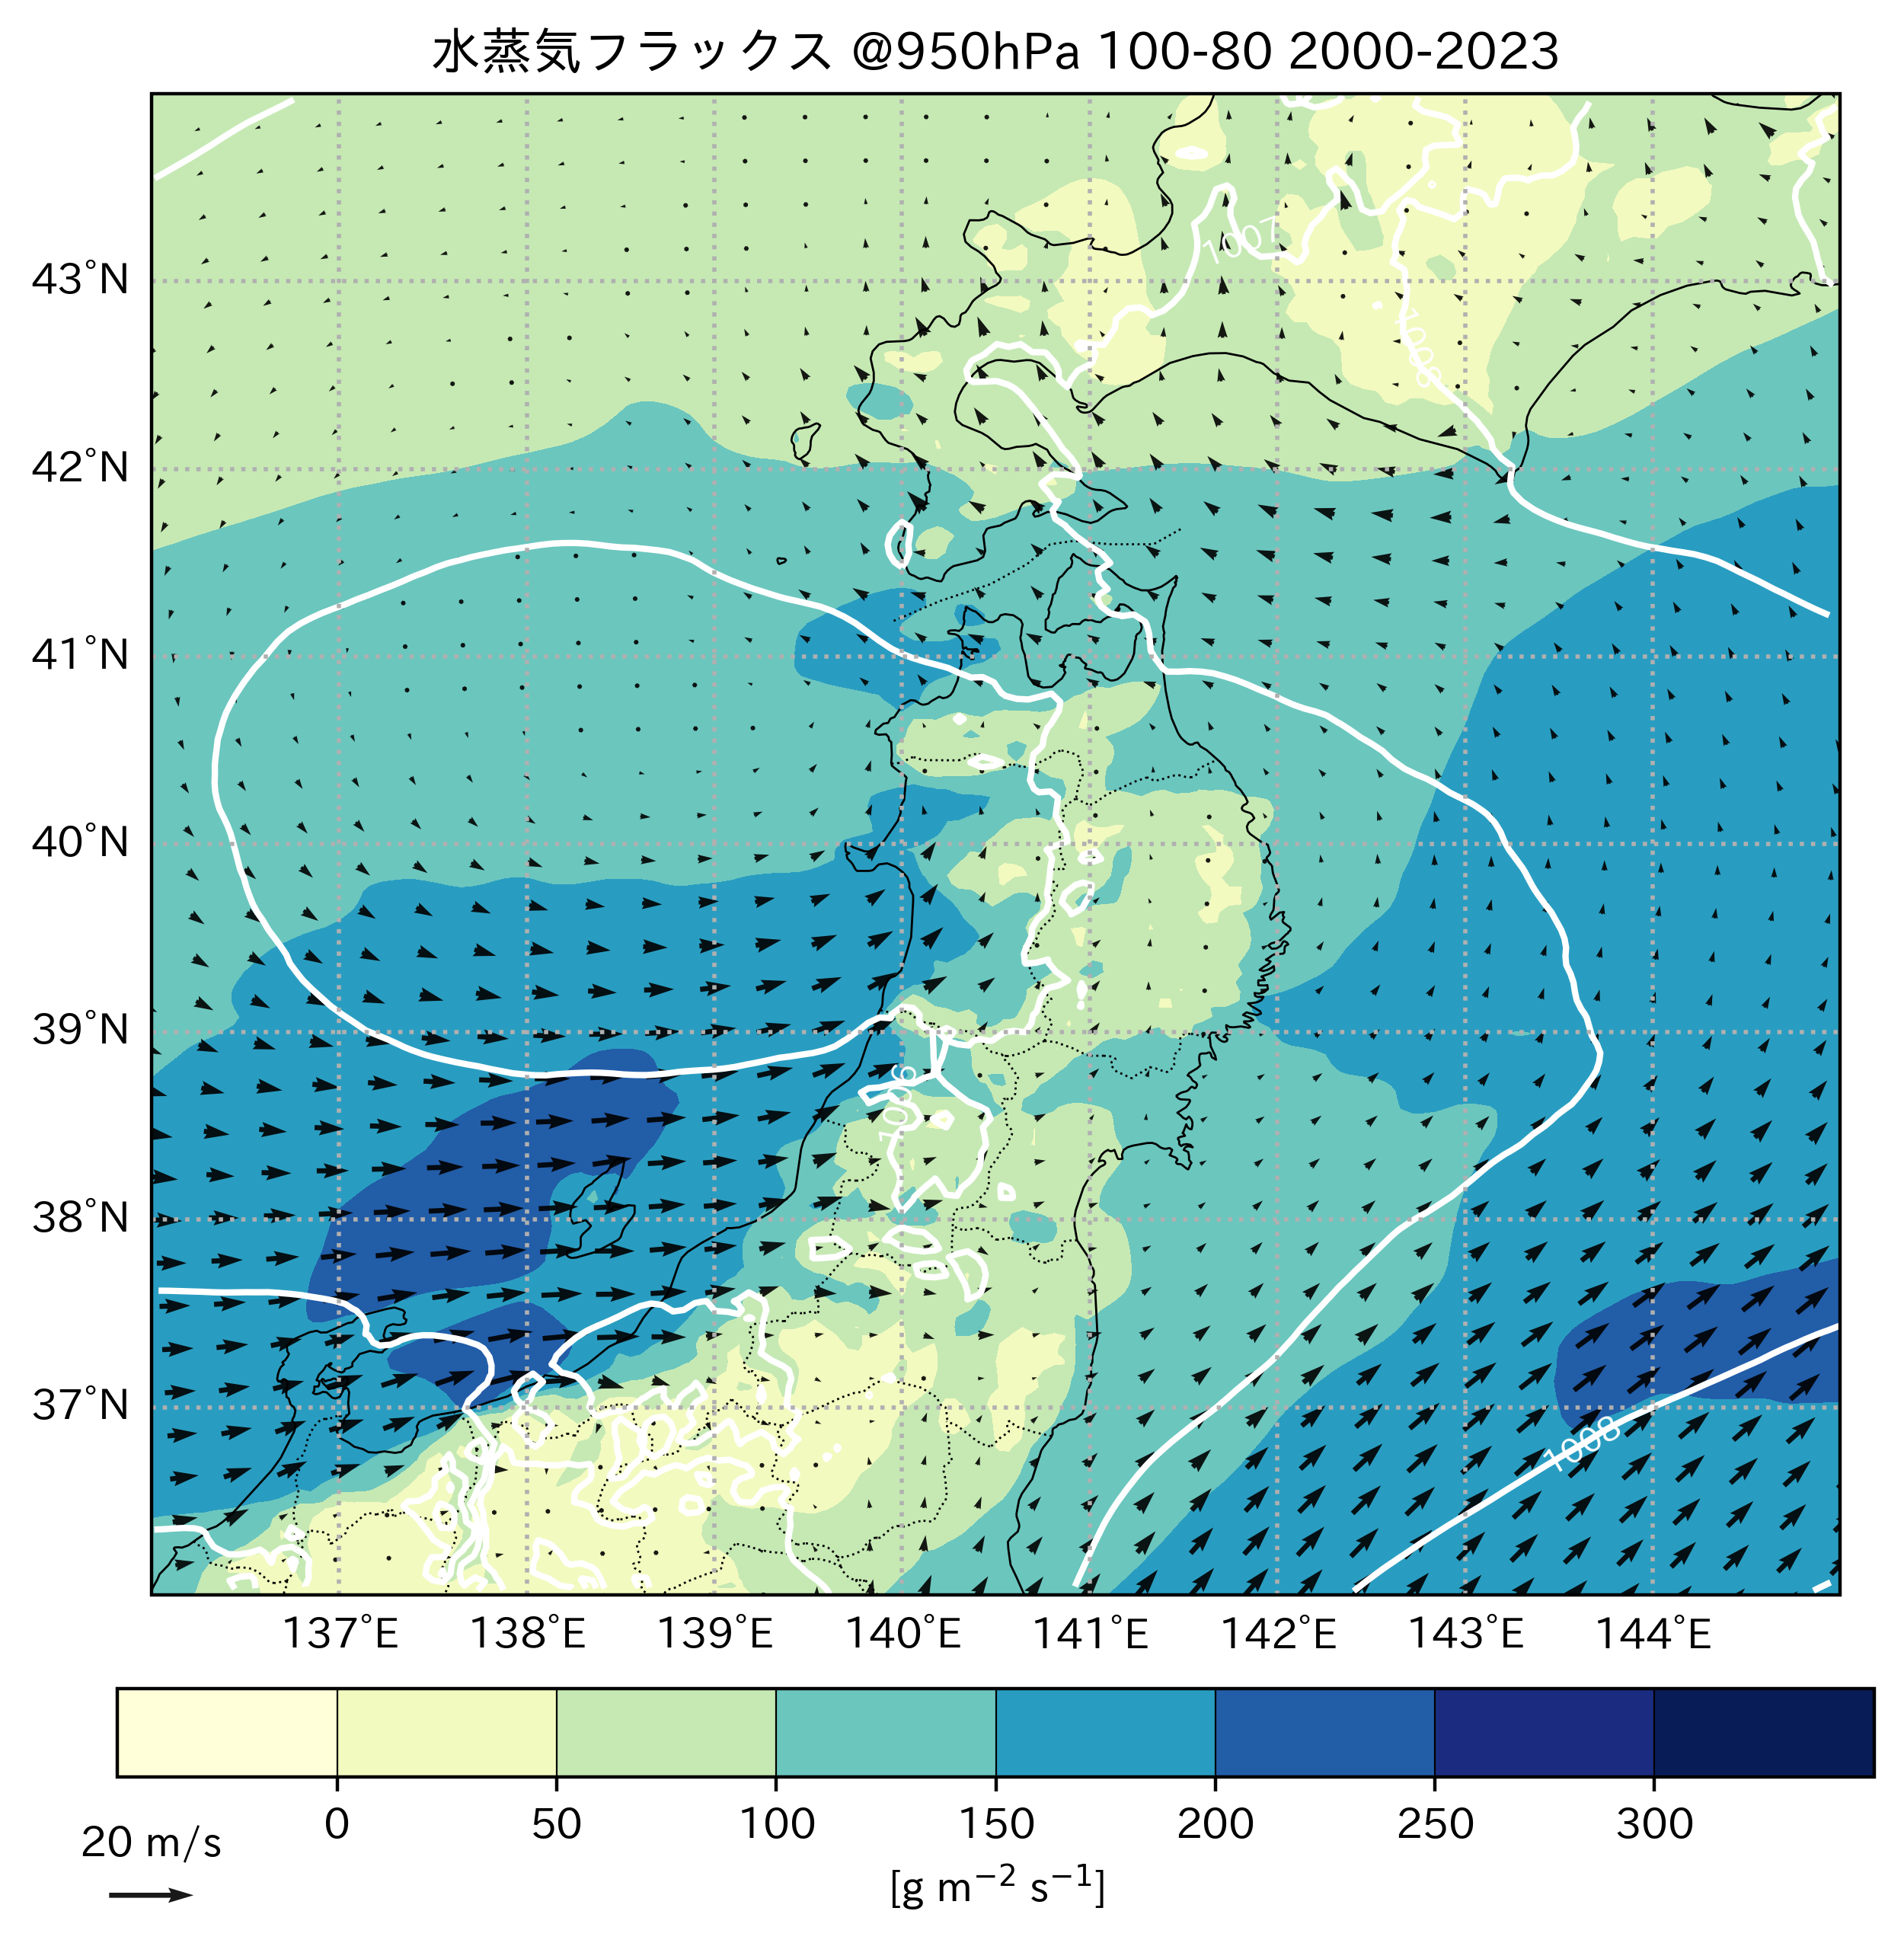

In [15]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_100-80_25.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_100-80_25.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_100-80_25.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_100-80_25.npy")

# 平均化
qV_data    = sum_ave_qV   / 13
U_data     = sum_ave_U    / 13
V_data     = sum_ave_V    / 13
MSLP_data  = sum_ave_MSLP / 13

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
#mslp_toho = np.where(mask, MSLP_data, np.nan)  # hPa換算

#cs = ax.contour(lon, lat, mslp_toho,
#                levels=range(980, 1040, 1),
#                colors='white', transform=proj)
#ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

# 平均化（すでに hPa の可能性あり）
MSLP_data = sum_ave_MSLP / 13  

# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 5
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=400, alpha=0.9, width=0.003
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

plt.show()


In [ ]:
#計算したほうが早いので多めのやつはデータ用意して描画

In [16]:
#100-80_all

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1002.3339601140037 1009.378758152052
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1002.3339601140037 1009.378758152052
29058.742713450425 29465.95971451576


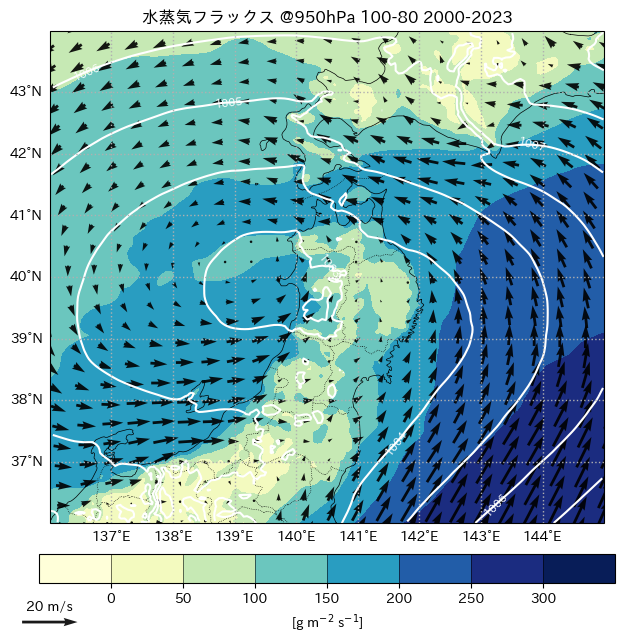

In [4]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_100-80_25_all.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_100-80_25_all.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_100-80_25_all.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_100-80_25_all.npy")

# 平均化
qV_data    = sum_ave_qV   / 29
U_data     = sum_ave_U    / 29
V_data     = sum_ave_V    / 29
MSLP_data  = sum_ave_MSLP / 29

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)

# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 7
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=200, alpha=0.9, width=0.005
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

figpath = f'/mnt/jet12/makoto/extract_senjo/environment/png/100-80_ratio25/flux/all_composite_flux_100-80_wind.png'
plt.savefig(figpath)
plt.show()



In [18]:
#090-70_all

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1002.3591738074063 1009.9326802845103
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1002.3591738074063 1009.9326802845103
57117.80570284154 57900.16760190121


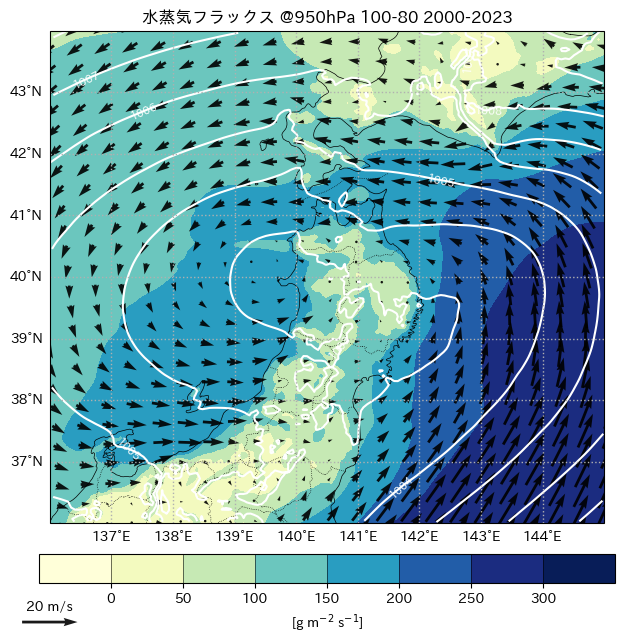

In [5]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_090-70_20_all.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_090-70_20_all.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_090-70_20_all.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_090-70_20_all.npy")

# 平均化
qV_data    = sum_ave_qV   / 57
U_data     = sum_ave_U    / 57
V_data     = sum_ave_V    / 57
MSLP_data  = sum_ave_MSLP / 57

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)

# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 7
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=200, alpha=0.9, width=0.005
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

#画像保存
figpath = f'/mnt/jet12/makoto/extract_senjo/environment/png/090-70/flux/all_composite_flux_wind_090-70_20_psea.png'
plt.savefig(figpath)
plt.show()

In [6]:
#100-80 nihonkai

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1005.060660276139 1009.33925650833
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1005.060660276139 1009.33925650833
13011.653812416156 13188.753646141591


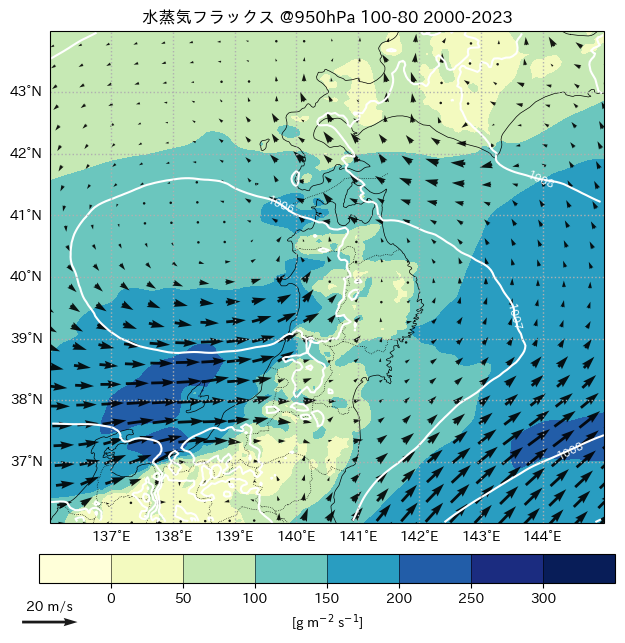

In [9]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_100-80_25_nihonkai.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_100-80_25_nihonkai.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_100-80_25_nihonkai.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_100-80_25_nihonkai.npy")

# 平均化
qV_data    = sum_ave_qV   / 13
U_data     = sum_ave_U    / 13
V_data     = sum_ave_V    / 13
MSLP_data  = sum_ave_MSLP / 13

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
#mslp_toho = np.where(mask, MSLP_data, np.nan)  # hPa換算

#cs = ax.contour(lon, lat, mslp_toho,
#                levels=range(980, 1040, 1),
#                colors='white', transform=proj)
#ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

# 平均化（すでに hPa の可能性あり）
MSLP_data = sum_ave_MSLP / 13  

# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 7
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=200, alpha=0.9, width=0.005
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

#画像保存
figpath = f'/mnt/jet12/makoto/extract_senjo/environment/png/100-80_ratio25/flux/all_composite_flux_wind_nihonkai.png'
plt.savefig(figpath)
plt.show()

In [10]:
#090-70 nihonkai

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1005.5835900704083 1009.803177216919
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1005.5835900704083 1009.803177216919
22052.83016889049 22309.168294147534


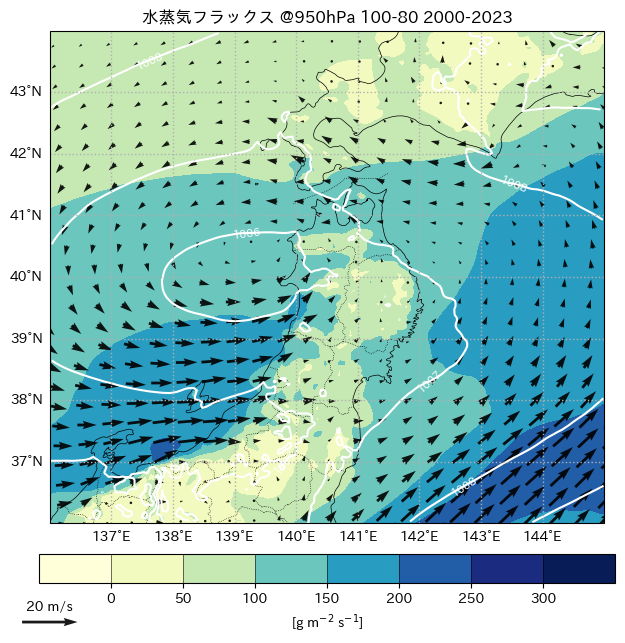

In [14]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_090-70_20_nihonkai.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_090-70_20_nihonkai.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_090-70_20_nihonkai.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_090-70_20_nihonkai.npy")

# 平均化
qV_data    = sum_ave_qV   / 22
U_data     = sum_ave_U    / 22
V_data     = sum_ave_V    / 22
MSLP_data  = sum_ave_MSLP / 22

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
#mslp_toho = np.where(mask, MSLP_data, np.nan)  # hPa換算

#cs = ax.contour(lon, lat, mslp_toho,
#                levels=range(980, 1040, 1),
#                colors='white', transform=proj)
#ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

# 平均化（すでに hPa の可能性あり）
#MSLP_data = sum_ave_MSLP / 13  

# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 7
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=200, alpha=0.9, width=0.005
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

#画像保存
figpath = f'/mnt/jet12/makoto/extract_senjo/environment/png/090-70/flux/all_composite_flux_wind_090-70_20_nihonkai_psea.png'
plt.savefig(figpath)
plt.show()

In [11]:
#090-70 taihei

Can't create file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/home/makoto/miniconda3/envs/makecsv/lib/python3.11/site-packages/cfgrib/messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Can't read index file '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2.5b7b6.idx'
Traceback (most recen

mslp_toho min/max: 1000.0196329497653 1010.192080478212
MSLP_data shape: (577, 721)
lon shape: (577, 721) lat shape: (577, 721)
mslp_toho min/max: 1000.0196329497653 1010.192080478212
34995.556865288556 35603.22686717932


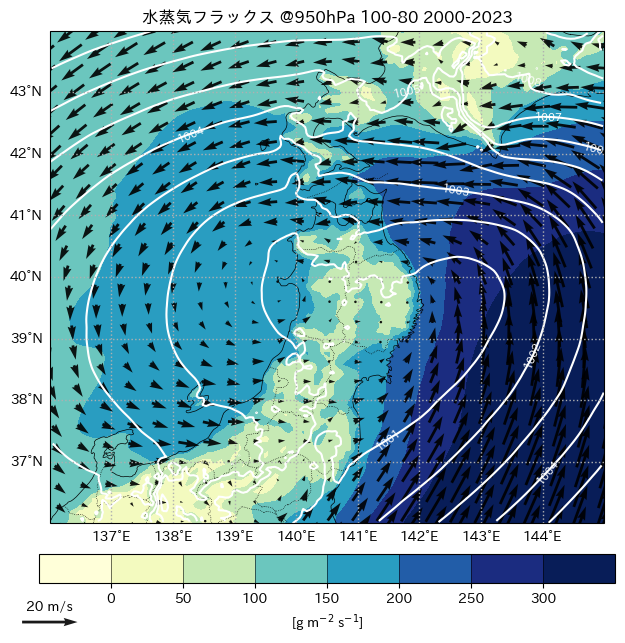

In [15]:
import numpy as np
import xarray as xr
import cfgrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

datapath = '/mnt/jet12/makoto/extract_senjo/environment/plot/py/data'
datapath2 = '/mnt/hail1/regional_RA/GRIB2/prs0/2019/ctrl/fcst_prs_201907150000.grib2'

# latlon
grb_file_xr = xr.open_dataset(datapath2, engine='cfgrib')
Ds = grb_file_xr
grb_file_xr.close()

# 計算済みデータの読み込み
sum_ave_qV   = np.load(f"{datapath}/sum_ave_qV_090-70_20_taihei.npy")
sum_ave_U    = np.load(f"{datapath}/sum_ave_U_090-70_20_taihei.npy")
sum_ave_V    = np.load(f"{datapath}/sum_ave_V_090-70_20_taihei.npy")
sum_ave_MSLP = np.load(f"{datapath}/sum_ave_MSLP_090-70_20_taihei.npy")

# 平均化
qV_data    = sum_ave_qV   / 35
U_data     = sum_ave_U    / 35
V_data     = sum_ave_V    / 35
MSLP_data  = sum_ave_MSLP / 35

# 緯度経度
lat = Ds['latitude'].values
lon = Ds['longitude'].values

# 東北地方の範囲
lat_d, lat_u = 36.0, 44.0
lon_l, lon_r = 136.0, 145.0

# プロット準備
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': proj})

# === 海面気圧（コンター） ===
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
#mslp_toho = np.where(mask, MSLP_data, np.nan)  # hPa換算

#cs = ax.contour(lon, lat, mslp_toho,
#                levels=range(980, 1040, 1),
#                colors='white', transform=proj)
#ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)


# 東北領域にマスク
mask = (lat >= lat_d) & (lat <= lat_u) & (lon >= lon_l) & (lon <= lon_r)
mslp_toho = np.where(mask, MSLP_data, np.nan)

cs = ax.contour(lon, lat, mslp_toho, levels=range(980, 1040, 1),
                colors='white', transform=proj)
ax.clabel(cs, inline=False, fontsize=8, fmt="%d", inline_spacing=0)

print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))


print("MSLP_data shape:", MSLP_data.shape)
print("lon shape:", lon.shape, "lat shape:", lat.shape)
print("mslp_toho min/max:", np.nanmin(mslp_toho), np.nanmax(mslp_toho))
print(sum_ave_MSLP.min(), sum_ave_MSLP.max())



# === 水蒸気フラックス（塗りつぶし） ===
vmin, vmax = 0, 300
levels = np.arange(vmin, vmax+50, 50)
im = ax.contourf(
    lon, lat, qV_data,
    levels=levels, cmap='YlGnBu',
    transform=ccrs.PlateCarree(),
    extend='both'
)
cbar = fig.colorbar(
    im, ax=ax, orientation='horizontal',
    pad=0.05, shrink=0.62,
    extendfrac='auto', extendrect=True,
    drawedges=True,
    ticks=levels,
    label='[g m$^{-2}$ s$^{-1}$]'
)

# === 風（ベクトル） ===
skip = 7
q1 = ax.quiver(
    lon[::skip, ::skip], lat[::skip, ::skip],
    U_data[::skip, ::skip], V_data[::skip, ::skip],
    color='black', scale=200, alpha=0.9, width=0.005
)
qk = 20
ax.quiverkey(q1, 0, -0.20, qk, f'{qk} m/s')

# === 地図要素 ===
countries_10m = cfeature.NaturalEarthFeature(
    'cultural', 'admin_1_states_provinces_lines',
    '10m', edgecolor='black', facecolor='none'
)

ax.set_extent([lon_l, lon_r, lat_d, lat_u])
ax.coastlines(resolution='10m', lw=0.5)
ax.add_feature(countries_10m, linestyle='dotted', linewidth=0.5, alpha=1.0)
gl = ax.gridlines(ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, linestyle=':')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 1))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 1))
gl.top_labels = False
gl.right_labels = False

ax.set_title('水蒸気フラックス @950hPa 100-80 2000-2023', fontsize=12)

#画像保存
figpath = f'/mnt/jet12/makoto/extract_senjo/environment/png/090-70/flux/all_composite_flux_wind_090-70_20_taihei_psea.png'
plt.savefig(figpath)
plt.show()